# [Synthetic Control](https://wiki.corp.kuaishou.com/pages/viewpage.action?spaceKey=ds&title=Synthetic+Control)

outcome: Z = $\begin{bmatrix}z_{1, 1} & ... & z_{1, j+1}\\... & ... & ...\\ z_{t, 1} & ... & z_{t, j+1}\end{bmatrix}$

predictors: X = $\begin{bmatrix}x_{1, 1} & ... & x_{1, j+1}\\... & ... & ...\\ x_{k, 1} & ... & x_{k, j+1}\end{bmatrix}$

V = $\begin{bmatrix}v_{1, 1} & ... & 0 \\... & ... & ...\\ 0 & ... & v_{k, k}\end{bmatrix}$，$v_{i,i}$代表了第i个predictor的重要性

W = $\begin{bmatrix}w_{1, 1}\\... \\ w_{j, 1}\end{bmatrix}$，$w_{j}$代表$z_{.,j}$的权重

解决这样一个问题：

$W^{*} = argmin(X_0W - X_1)^TV(X_0W - X_1)$

$V^{*} = argmin(Z_0W - Z_1)^T(Z_0W - Z_1)$

In [1]:
# import packages
import sys
sys.path.append('/home/ds/pyfuns')
import pandas as pd 
from myutil import query_hive,execute_hive
%matplotlib inline
import pylab, math
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from datetime import time, datetime
import datetime, time
import matplotlib.font_manager as fm
zhfont = fm.FontProperties(fname='msyh.ttf')
import datetime as dt
sys.path.append('/home/public/CausalInference')
from Synth import Synth
import warnings
warnings.filterwarnings('ignore')

myutil version 0.2.0


## 构造的例子

1. 效果不是非常理想，control组太少

In [2]:
# 准备X和y
predictors = pd.DataFrame({'a':[3,1,6,1], 'b':[4,2,5,0], 'c':[5,2,3,5],
                         'd':[4,2,4,2], 'e': [3,4,7,2]},index=['A','B','C','D'])

outcome = pd.DataFrame({'a':[11,10,12,13,13,12,13], 'b':[8,8,10,11,11,11,12],
                         'c':[20,21,25,27,27,28,29], 'd':[16,17,22,25,25,26,27],
                         'e':[14,14,17,20,21,21,23]}, 
                         index=[2010,2011,2012,2013,2014,2015,2016])

In [3]:
# 定义control和treated组，生成syn object
control_units = ['b', 'c', 'd', 'e']
treated_unit = 'a'

syn = Synth(outcome, predictors, control_units, treated_unit,
            [2010, 2011, 2012, 2013, 2014], 
            [2015, 2016])

In [4]:
# 给出synth的y，W和V
syn.get_estimate(syn.X0, syn.X1, syn.Z0, syn.Z1, syn.Z_all_control)

(array([ 9.72184937,  9.72184937, 12.00882427, 13.58277406, 13.86974895,
        13.86974895, 15.15672385]),
 array([7.13025105e-01, 0.00000000e+00, 1.95156391e-18, 2.86974895e-01]),
 array([0.06876624, 0.20088066, 1.        , 0.01680467, 0.97729785]))

In [5]:
# 给出合成的predictors和y
synths, ate = syn.summary(syn.Z_all_treated, if_show = True,  if_cv = False, 
                          X0 = syn.X0, X1 = syn.X1, Z0 = syn.Z0, Z1 = syn.Z1, Z_control = syn.Z_all_control)

Predictors: 

--------------------
      Actual  Synthetic
0   4.008919   4.961739
1   1.020621   2.627027
2   4.242641   3.941378
3   0.597614   0.343001
0  11.800000  11.781009


Causal Effects: 

--------------------
      Actual  Synthetic
2010      11   9.721849
2011      10   9.721849
2012      12  12.008824
2013      13  13.582774
2014      13  13.869749
2015      12  13.869749
2016      13  15.156724


average treatment effect: -2.01324


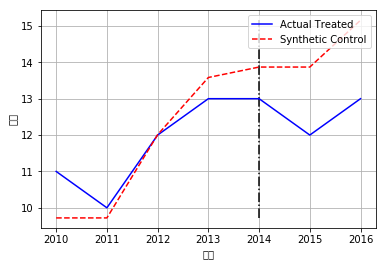

In [6]:
# 画图
syn.plot(u'日期', u'时长', 2014, step = 1, 
         Z_treated = syn.Z_all_treated, if_show = False, 
         X0 = syn.X0, X1 = syn.X1, Z0 = syn.Z0, Z1 = syn.Z1, Z_control = syn.Z_all_control)

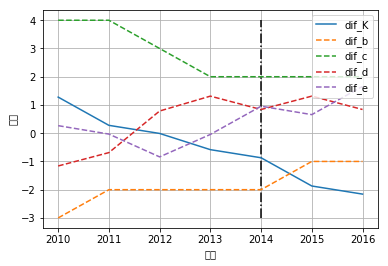

In [4]:
syn.placebo_test(u'日期', u'时长', 2014, step = 1)

## 快手平台上的例子

In [5]:
# Z1: 从hive取k歌用户在4/1/2018-5/31/2018期间的发作品量，作品被观看时长
data = query_hive("""
with K_base as 
(
select author_id
from ks_dw_dim.dw_dim_photo_narrow
where p_date between '20180501' and '20180531'
and photo_duration/1000 between 10 and 300
and is_karaoke = 1 
and language like '%zh'
group by author_id
)

select count(distinct photo_id) as K_cnt, 
count(distinct a.author_id) as K_people, p_date
from
(
    (select photo_id, author_id, p_date
    from ks_dw_dim.dw_dim_photo_narrow
    where p_date between '20180401' and '20180531'
    and photo_duration/1000 between 10 and 300
    and language like '%zh') as a

    left outer join

    (select * from K_base) b
    on a.author_id=b.author_id
    ) 
where b.author_id is not null
group by p_date
""",silent=True)
K_Z1 = pd.DataFrame(data, columns=['K_upload', 'K_people', 'p_date'])
K_Z1['per_upload'] = K_Z1.K_upload*1.0/K_Z1.K_people

In [6]:
# X1
data = query_hive("""
with K_base as 
(select author_id
from ks_dw_dim.dw_dim_photo_narrow
where p_date between '20180501' and '20180531'
and photo_duration/1000 between 10 and 300
and is_karaoke = 1 
and language like '%zh'
group by author_id)

select avg(click_time), avg(comment_times), avg(like_times),
avg(negative_times), avg(app_times),
avg(follow_times), avg(forward_times)
from
    (select avg(click_times) as click_time, avg(comment_times) as comment_times,
    avg(like_times) as like_times, avg(negative_times) as negative_times, 
    avg(follow_times) as follow_times, avg(forward_times) as forward_times,
    p_date
    from
        (select author_id, sum(client_click_times) as click_times,
        sum(follow_times) as follow_times, sum(forward_times) as forward_times,
        sum(comment_times) as comment_times, sum(like_times) as like_times,
        sum(negative_times) as negative_times, p_date
        from ks_dws.dw_dws_photo_photoid_di
        where p_date between '20180401' and '20180430'
        group by author_id, p_date) a

        left outer join

        (select author_id from K_base) b
        on a.author_id = b.author_id
    where b.author_id is not null
    group by p_date) a

    left outer join

    (select avg(useage_time) as app_times, p_date
    from
        (select user_id, 
        (case when min(useage_time) is null then 0
        when min(useage_time/60) >= 60*24 then 60*24
        else min(useage_time/60) end) as useage_time, p_date
        from ks_dws.dws_user_active_analysis_di
        where p_date between '20180401' and '20180430'
        group by user_id, p_date) a

        left outer join

        (select author_id from K_base) b
        on a.user_id = b.author_id
    where b.author_id is not null
    group by p_date) b
    on a.p_date = b.p_date
""",silent=True)
K_X1 = pd.DataFrame(data, columns = ['click', 'comment', 'like', 'negative', 'app', 'follow', 'forward'])

In [7]:
# Z0: 从hive取非k歌用户在4/1/2018-5/31/2018期间的发作品量
data = query_hive("""
with notK_base as
(select author_id
from
(select author_id, sum(is_karaoke) as if_karaoke
from ks_dw_dim.dw_dim_photo_narrow
where p_date between '20180501' and '20180531'
and photo_duration/1000 between 10 and 300
and language like '%zh'
group by author_id
) a
where if_karaoke = 0
)

select count(distinct photo_id) as notK_cnt, 
count(distinct a.author_id) as notK_people, fans_range, p_date
from
(
(select photo_id, author_id, p_date
from ks_dw_dim.dw_dim_photo_narrow
where p_date between '20180401' and '20180531'
and photo_duration/1000 between 10 and 300
and language like '%zh') a

left outer join

(select * from notK_base) b
on a.author_id=b.author_id

left outer join

(select 
(case when min(fan_count) < 1000 then 'a. 0-1k'
when min(fan_count) < 10000 then 'b. 1k-1w'
when min(fan_count) < 100000 then 'c. 1w-10w'
when min(fan_count) < 1000000 then 'd. 10w-100w'
else 'e. 100w+' end) as fans_range, user_id
from ks_dw_dim.dw_dim_user_df
where p_date = '20180501'
group by user_id) c
on a.author_id=c.user_id
)
where b.author_id is not null and c.user_id is not null
group by p_date, fans_range
""",silent=True)
K_Z0 = pd.DataFrame(data, columns=['notK_upload', 'notK_people', 'fans_range', 'p_date'])
K_Z0['per_upload'] = K_Z0.notK_upload*1.0/K_Z0.notK_people

In [8]:
# X0
data = query_hive("""
with notK_base as
(select author_id
from
(select author_id, sum(is_karaoke) as if_karaoke
from ks_dw_dim.dw_dim_photo_narrow
where p_date between '20180501' and '20180531'
and photo_duration/1000 between 10 and 300
and language like '%zh'
group by author_id
) a
where if_karaoke = 0),

author_base as
(select a.author_id, b.fans_range
from
    (select * from notK_base) a

    left outer join

    (select 
    (case when min(fan_count) < 1000 then 'a. 0-1k'
    when min(fan_count) < 10000 then 'b. 1k-1w'
    when min(fan_count) < 100000 then 'c. 1w-10w'
    when min(fan_count) < 1000000 then 'd. 10w-100w'
    else 'e. 100w+' end) as fans_range, user_id
    from ks_dw_dim.dw_dim_user_df
    where p_date = '20180501'
    group by user_id) b
    on a.author_id = b.user_id
where b.user_id is not null)

select avg(click_time), avg(comment_times), avg(like_times),
avg(negative_times), avg(app_times),
avg(follow_times), avg(forward_times),
a.fans_range
from
    (select avg(click_times) as click_time, avg(comment_times) as comment_times,
    avg(like_times) as like_times, avg(negative_times) as negative_times, 
    avg(follow_times) as follow_times, avg(forward_times) as forward_times,
    p_date, fans_range
    from
        (select author_id, sum(client_click_times) as click_times,
        sum(follow_times) as follow_times, sum(forward_times) as forward_times,
        sum(comment_times) as comment_times, sum(like_times) as like_times,
        sum(negative_times) as negative_times, p_date
        from ks_dws.dw_dws_photo_photoid_di
        where p_date between '20180401' and '20180430'
        group by author_id, p_date) a

        left outer join

        (select * from author_base) b
        on a.author_id = b.author_id
    where b.author_id is not null
    group by p_date, fans_range) a

    left outer join

    (select avg(useage_time) as app_times, p_date, fans_range
    from
        (select user_id, 
        (case when min(useage_time) is null then 0
        when min(useage_time/60) >= 60*24 then 60*24
        else min(useage_time/60) end) as useage_time, p_date
        from ks_dws.dws_user_active_analysis_di
        where p_date between '20180401' and '20180430'
        group by user_id, p_date) a

        left outer join

        (select * from author_base) b
        on a.user_id = b.author_id
    where b.author_id is not null
    group by p_date, fans_range) b
    on a.p_date = b.p_date and a.fans_range = b.fans_range
group by a.fans_range
""",silent=True)
K_X0 = pd.DataFrame(data, columns = ['click', 'comment', 'like', 'negative', 'app', 'follow', 'forward', 'fans_range'])
K_X0['fans_range']  = K_X0.fans_range.map(lambda x : x.strip())

In [9]:
# data processing
Z = K_Z1[['p_date', 'per_upload']]
Z.columns = ['p_date', 'K_upload']
for name, temp in K_Z0.groupby('fans_range'):
    temp.reset_index(drop=True, inplace=True)
    temp = temp[['p_date', 'per_upload']]
    temp.columns = ['p_date', name + '_upload']
    Z = pd.merge(Z, temp, on = 'p_date', how = 'left')   
K_X1['fans_range'] = ['K']
X = K_X1.T
X.columns = ['K']
X = pd.concat([X, K_X0.T], axis = 1)
X.columns = X.loc['fans_range']
del X.columns.name

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

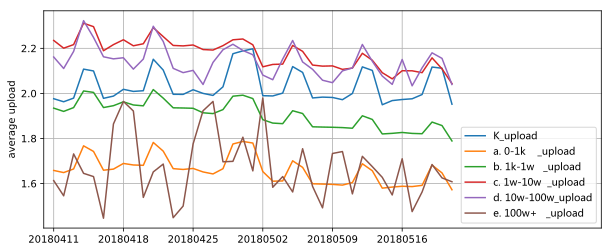

In [8]:
# 画不同粉丝数的非k歌的人均发作品量和k歌的人均发作品量
plt.figure(figsize = (10, 4))
xvalue = Z.p_date[10:51]
x = range(len(xvalue))
for i in range(1, 7):
    plt.plot(x, Z.ix[10:50,i], label = Z.columns[i])
plt.legend(prop = zhfont, loc = 4)
plt.ylabel('average upload')
plt.xticks(x[::7], xvalue[::7])
plt.xlim(-1, x[-1] + 15)
plt.grid(True)

In [11]:
Z.set_index('p_date', inplace=True)
del Z.index.name
Z.columns = X.columns
Z.head()

,K,a. 0-1k,b. 1k-1w,c. 1w-10w,d. 10w-100w,e. 100w+
20180401,2.073873,1.724740,1.996401,2.328368,2.290212,2.037736
20180402,1.937885,1.629912,1.922938,2.246979,2.196798,1.517241
20180403,1.928633,1.632307,1.927370,2.242290,2.186687,1.639344
20180404,1.954114,1.647564,1.935624,2.271985,2.222935,1.571429
20180405,2.076644,1.762556,1.947668,2.159374,2.007916,1.469388


In [12]:
X = X.ix[:7,]
X

,K,a. 0-1k,b. 1k-1w,c. 1w-10w,d. 10w-100w,e. 100w+
click,301.749,85.6309,1163.13,10146.2,62491,436040
comment,5.69819,2.38813,11.8171,38.9884,190.419,1315.55
like,13.1828,4.86876,35.5343,229.839,1558.03,13598.4
negative,2.21037,0.36994,5.09994,58.4937,323.435,1216.05
app,91.1256,65.2881,99.6529,131.686,175.922,269.671
follow,0.652428,0.134915,3.09866,32.99,181.494,743.676
forward,0.205577,0.0579196,0.646793,7.00699,41.9106,355.031


### 全量数据

$y = \beta_0 + \beta_1T + \beta_2I(treated) + \beta_3T*I(treated)$

In [13]:
# 生成全量数据的syn object
syn = Synth(Z, X, X.columns[1:].tolist(), X.columns[0], Z.index.tolist()[10:30], Z.index.tolist()[30:50])

average treatment effect: 0.09513


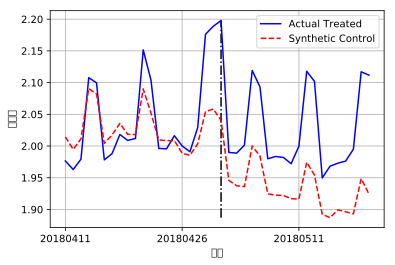

In [14]:
# 画图
syn.plot(u'日期', u'作品量', u'20180501', step = 15, 
         Z_treated = syn.Z_all_treated, if_show = False, 
         X0 = syn.X0, X1 = syn.X1, Z0 = syn.Z0, Z1 = syn.Z1, Z_control = syn.Z_all_control)

In [15]:
# 得到合成的结果
a, _ = syn.summary(syn.Z_all_treated, False, 
                   X0 = syn.X0, X1 = syn.X1, Z0 = syn.Z0, Z1 = syn.Z1, Z_control = syn.Z_all_control)

In [16]:
syn.check_fit(a.ix[:20, 'Actual'], a.ix[:20, 'Synthetic'])

Since p-value of difference between treated and synthic treated is 0.072 and 0.229, we have 95% confidence to say that our model fits well


In [17]:
syn.get_estimate(syn.X0, syn.X1, syn.Z0, syn.Z1, syn.Z_all_control)

(array([2.01439715, 1.99463766, 2.01130013, 2.09069159, 2.08198101,
        2.00417576, 2.01749313, 2.03577735, 2.01842519, 2.01802505,
        2.09001659, 2.05158621, 2.00960041, 2.00845154, 2.00861969,
        1.9885142 , 1.98532408, 2.00351251, 2.05410692, 2.05835774,
        2.04047715, 1.94573491, 1.93741492, 1.93591692, 2.00003095,
        1.98406475, 1.92456121, 1.92242295, 1.92204446, 1.91690581,
        1.91631586, 1.97435352, 1.95422408, 1.89227509, 1.88696084,
        1.89939454, 1.89623707, 1.89301639, 1.94849561, 1.9241551 ]),
 array([0.        , 0.73436987, 0.26563013, 0.        , 0.        ]),
 array([1.10553568e-02, 0.00000000e+00, 0.00000000e+00, 1.20490211e-07,
        0.00000000e+00, 7.53010294e-01, 8.95338301e-08, 1.00000000e+00]))

### 筛选较相似的control组数据 - 去掉1k-1w粉丝层作者

In [34]:
# 筛选相似的control组
ZZ = Z.ix[:, [0,1,3,4,5]]
XX = X.ix[[0,1,2,3,4,5,6], [0,1,3,4,5]]

In [35]:
# 生成新的syn object
syn = Synth(ZZ, XX, XX.columns[1:].tolist(), XX.columns[0], 
            ZZ.index.tolist()[10:30],
            ZZ.index.tolist()[30:50])

average treatment effect: 0.08554


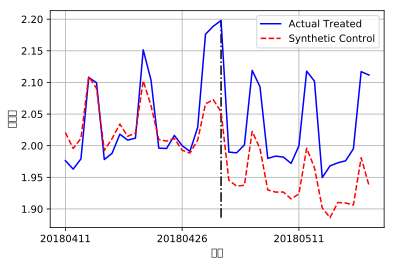

In [36]:
# 画图
syn.plot(u'日期', u'作品量', u'20180501', step = 15, 
         Z_treated = syn.Z_all_treated, if_show = False, 
         X0 = syn.X0, X1 = syn.X1, Z0 = syn.Z0, Z1 = syn.Z1, Z_control = syn.Z_all_control)

average treatment effect: 0.08554


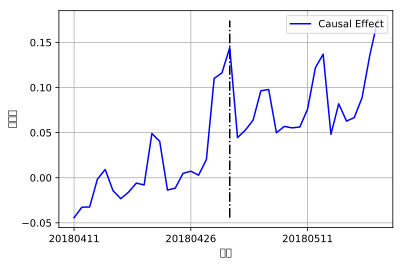

In [37]:
# 画causal effect图
syn.plot(u'日期', u'作品量', u'20180501', step = 15, estimate = True,
         Z_treated = syn.Z_all_treated, if_show = False, 
         X0 = syn.X0, X1 = syn.X1, Z0 = syn.Z0, Z1 = syn.Z1, Z_control = syn.Z_all_control)

### google causalimpact

In [76]:
ZZ.ix[10:50, :].to_csv('synth_data.csv', encoding='utf-8')

In [80]:
%load_ext rpy2.ipython

In [85]:
#
# %%R
# library(CausalImpact)

# # example of karaoke
# # set desktop as a working directory
# df = read.csv('synth_data.csv')
# df = df[, -1]
# colnames(df) = c('a', 'b', 'c', 'd', 'e')
# time.points = seq.Date(as.Date("2018-04-11"), by = 1, length.out = 40)
# data = zoo(df, time.points)

# # plot the line
# matplot(data, type = "l")

# # run analysis
# pre.period <- as.Date(c("2018-04-01", "2018-04-30"))
# post.period <- as.Date(c("2018-05-01", "2018-05-20"))
# impact <- CausalImpact(data, pre.period, post.period)

# # plot the result
# plot(impact)
# summary(impact)

# # report of analysis
# summary(impact, "report")

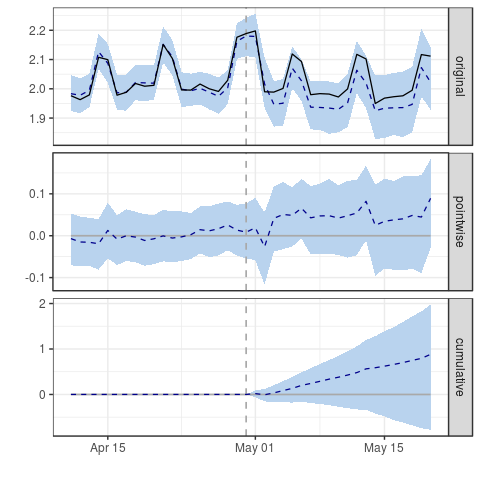

In [84]:
%%R
plot(impact)

## 进一步分层

In [38]:
# Z1: 从hive取k歌用户在4/1/2018-5/31/2018期间的发作品量，作品被观看时长
data = query_hive("""
with K_base as 
(
select author_id
from ks_dw_dim.dw_dim_photo_narrow
where p_date between '20180501' and '20180531'
and photo_duration/1000 between 10 and 300
and is_karaoke = 1 
and language like '%zh'
group by author_id
)

select count(distinct photo_id) as K_cnt, 
count(distinct a.author_id) as K_people, p_date
from
(
    (select photo_id, author_id, p_date
    from ks_dw_dim.dw_dim_photo_narrow
    where p_date between '20180401' and '20180531'
    and photo_duration/1000 between 10 and 300
    and language like '%zh') as a

    left outer join

    (select * from K_base) b
    on a.author_id=b.author_id
    ) 
where b.author_id is not null
group by p_date
""",silent=True)
K_Z1 = pd.DataFrame(data, columns=['K_upload', 'K_people', 'p_date'])
K_Z1['per_upload'] = K_Z1.K_upload*1.0/K_Z1.K_people

In [39]:
# X1
data = query_hive("""
with K_base as 
(select author_id
from ks_dw_dim.dw_dim_photo_narrow
where p_date between '20180501' and '20180531'
and photo_duration/1000 between 10 and 300
and is_karaoke = 1 
and language like '%zh'
group by author_id)

select avg(click_time), avg(comment_times), avg(like_times),
avg(negative_times), avg(app_times),
avg(follow_times), avg(forward_times)
from
    (select avg(click_times) as click_time, avg(comment_times) as comment_times,
    avg(like_times) as like_times, avg(negative_times) as negative_times, 
    avg(follow_times) as follow_times, avg(forward_times) as forward_times,
    p_date
    from
        (select author_id, sum(client_click_times) as click_times,
        sum(follow_times) as follow_times, sum(forward_times) as forward_times,
        sum(comment_times) as comment_times, sum(like_times) as like_times,
        sum(negative_times) as negative_times, p_date
        from ks_dws.dw_dws_photo_photoid_di
        where p_date between '20180401' and '20180430'
        group by author_id, p_date) a

        left outer join

        (select author_id from K_base) b
        on a.author_id = b.author_id
    where b.author_id is not null
    group by p_date) a

    left outer join

    (select avg(useage_time) as app_times, p_date
    from
        (select user_id, 
        (case when min(useage_time) is null then 0
        when min(useage_time/60) >= 60*24 then 60*24
        else min(useage_time/60) end) as useage_time, p_date
        from ks_dws.dws_user_active_analysis_di
        where p_date between '20180401' and '20180430'
        group by user_id, p_date) a

        left outer join

        (select author_id from K_base) b
        on a.user_id = b.author_id
    where b.author_id is not null
    group by p_date) b
    on a.p_date = b.p_date
""",silent=True)
K_X1 = pd.DataFrame(data, columns = ['click', 'comment', 'like', 'negative', 'app', 'follow', 'forward'])

In [40]:
# Z0: 从hive取非k歌用户在4/1/2018-5/31/2018期间的发作品量
data = query_hive("""
with notK_base as
(select author_id
from
(select author_id, sum(is_karaoke) as if_karaoke
from ks_dw_dim.dw_dim_photo_narrow
where p_date between '20180501' and '20180531'
and photo_duration/1000 between 10 and 300
and language like '%zh'
group by author_id
) a
where if_karaoke = 0
)

select count(distinct photo_id) as notK_cnt, 
count(distinct a.author_id) as notK_people, fans_range, p_date
from
(
(select photo_id, author_id, p_date
from ks_dw_dim.dw_dim_photo_narrow
where p_date between '20180401' and '20180531'
and photo_duration/1000 between 10 and 300
and language like '%zh') a

left outer join

(select * from notK_base) b
on a.author_id=b.author_id

left outer join

(select 
(case when min(fan_count) < 100 then 'a. 0-100'
when min(fan_count) < 1000 then 'b. 100-1k'
when min(fan_count) < 10000 then 'c. 1k-1w'
when min(fan_count) < 50000 then 'd. 1w-5w'
when min(fan_count) < 100000 then 'e. 5w-10w'
when min(fan_count) < 500000 then 'f. 10w-50w'
when min(fan_count) < 1000000 then 'g. 50w-100w'
when min(fan_count) < 50000000 then 'h. 100w-500w'
when min(fan_count) < 100000000 then 'i. 500w-1000w'
else 'j. 1000w+' end) as fans_range, user_id
from ks_dw_dim.dw_dim_user_df
where p_date = '20180501'
group by user_id) c
on a.author_id=c.user_id
)
where b.author_id is not null and c.user_id is not null
group by p_date, fans_range
""",silent=True)
K_Z0 = pd.DataFrame(data, columns=['notK_upload', 'notK_people', 'fans_range', 'p_date'])
K_Z0['per_upload'] = K_Z0.notK_upload*1.0/K_Z0.notK_people

In [41]:
# X0
data = query_hive("""
with notK_base as
(select author_id
from
(select author_id, sum(is_karaoke) as if_karaoke
from ks_dw_dim.dw_dim_photo_narrow
where p_date between '20180501' and '20180531'
and photo_duration/1000 between 10 and 300
and language like '%zh'
group by author_id
) a
where if_karaoke = 0),

author_base as
(select a.author_id, b.fans_range
from
    (select * from notK_base) a

    left outer join

    (select 
    (case when min(fan_count) < 100 then 'a. 0-100'
    when min(fan_count) < 1000 then 'b. 100-1k'
    when min(fan_count) < 10000 then 'c. 1k-1w'
    when min(fan_count) < 50000 then 'd. 1w-5w'
    when min(fan_count) < 100000 then 'e. 5w-10w'
    when min(fan_count) < 500000 then 'f. 10w-50w'
    when min(fan_count) < 1000000 then 'g. 50w-100w'
    when min(fan_count) < 50000000 then 'h. 100w-500w'
    when min(fan_count) < 100000000 then 'i. 500w-1000w'
    else 'j. 1000w+' end) as fans_range, user_id
    from ks_dw_dim.dw_dim_user_df
    where p_date = '20180501'
    group by user_id) b
    on a.author_id = b.user_id
where b.user_id is not null)

select avg(click_time), avg(comment_times), avg(like_times),
avg(negative_times), avg(app_times),
avg(follow_times), avg(forward_times),
a.fans_range
from
    (select avg(click_times) as click_time, avg(comment_times) as comment_times,
    avg(like_times) as like_times, avg(negative_times) as negative_times, 
    avg(follow_times) as follow_times, avg(forward_times) as forward_times,
    p_date, fans_range
    from
        (select author_id, sum(client_click_times) as click_times,
        sum(follow_times) as follow_times, sum(forward_times) as forward_times,
        sum(comment_times) as comment_times, sum(like_times) as like_times,
        sum(negative_times) as negative_times, p_date
        from ks_dws.dw_dws_photo_photoid_di
        where p_date between '20180401' and '20180430'
        group by author_id, p_date) a

        left outer join

        (select * from author_base) b
        on a.author_id = b.author_id
    where b.author_id is not null
    group by p_date, fans_range) a

    left outer join

    (select avg(useage_time) as app_times, p_date, fans_range
    from
        (select user_id, 
        (case when min(useage_time) is null then 0
        when min(useage_time/60) >= 60*24 then 60*24
        else min(useage_time/60) end) as useage_time, p_date
        from ks_dws.dws_user_active_analysis_di
        where p_date between '20180401' and '20180430'
        group by user_id, p_date) a

        left outer join

        (select * from author_base) b
        on a.user_id = b.author_id
    where b.author_id is not null
    group by p_date, fans_range) b
    on a.p_date = b.p_date and a.fans_range = b.fans_range
group by a.fans_range
""",silent=True)
K_X0 = pd.DataFrame(data, columns = ['click', 'comment', 'like', 'negative', 'app', 'follow', 'forward', 'fans_range'])
K_X0['fans_range']  = K_X0.fans_range.map(lambda x : x.strip())

In [42]:
# data processing
Z = K_Z1[['p_date', 'per_upload']]
Z.columns = ['p_date', 'K_upload']
for name, temp in K_Z0.groupby('fans_range'):
    temp.reset_index(drop=True, inplace=True)
    temp = temp[['p_date', 'per_upload']]
    temp.columns = ['p_date', name + '_upload']
    Z = pd.merge(Z, temp, on = 'p_date', how = 'left')   
K_X1['fans_range'] = ['K']
X = K_X1.T
X.columns = ['K']
X = pd.concat([X, K_X0.T], axis = 1)
X.columns = X.loc['fans_range']
del X.columns.name

In [43]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

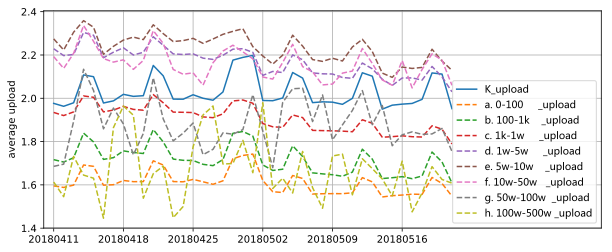

In [8]:
# 画不同粉丝数的非k歌的人均发作品量和k歌的人均发作品量
plt.figure(figsize = (10, 4))
xvalue = Z.p_date[10:51]
x = range(len(xvalue))
for i in range(1, 10):
    if i != 1:
        linestyle = '--'
    else:
        linestyle = '-'
    plt.plot(x, Z.ix[10:50,i], label = Z.columns[i], linestyle = linestyle)
plt.legend(prop = zhfont, loc = 4)
plt.ylabel('average upload')
plt.xticks(x[::7], xvalue[::7])
plt.xlim(-1, x[-1] + 15)
plt.grid(True)

In [44]:
Z.set_index('p_date', inplace=True)
del Z.index.name
Z.columns = X.columns
Z.head()

,K,a. 0-100,b. 100-1k,c. 1k-1w,d. 1w-5w,e. 5w-10w,f. 10w-50w,g. 50w-100w,h. 100w-500w
20180401,2.073873,1.665950,1.780279,1.996401,2.316794,2.401129,2.307935,2.030769,2.037736
20180402,1.937885,1.571492,1.684296,1.922938,2.236997,2.308780,2.207620,2.040000,1.517241
20180403,1.928633,1.574562,1.686312,1.927370,2.233360,2.296812,2.191602,2.116000,1.639344
20180404,1.954114,1.584689,1.705110,1.935624,2.261338,2.337056,2.246353,1.901887,1.571429
20180405,2.076644,1.697319,1.825199,1.947668,2.157263,2.173165,2.033613,1.590244,1.469388


In [45]:
X = X.ix[:7,]
X

,K,a. 0-100,b. 100-1k,c. 1k-1w,d. 1w-5w,e. 5w-10w,f. 10w-50w,g. 50w-100w,h. 100w-500w
click,301.749,37.0692,163.746,1163.13,8172.45,23703.1,52096.2,192850,436040
comment,5.69819,0.581467,5.30528,11.8171,33.438,77.1108,160.215,569.151,1315.55
like,13.1828,1.27462,10.669,35.5343,184.638,540.284,1271.77,5147.99,13598.4
negative,2.21037,0.179783,0.675149,5.09994,46.2392,142.668,291.104,728.877,1216.05
app,91.1256,57.037,82.4452,99.6529,129.227,148.543,172.053,223.263,269.671
follow,0.652428,0.0543484,0.264373,3.09866,26.8112,75.4222,155.266,510.494,743.676
forward,0.205577,0.0358053,0.0932005,0.646793,5.61993,16.5321,34.9327,129.427,355.031


In [46]:
syn = Synth(Z, X, X.columns[1:].tolist(), X.columns[0], Z.index.tolist()[10:30], Z.index.tolist()[30:50])

average treatment effect: 0.08330


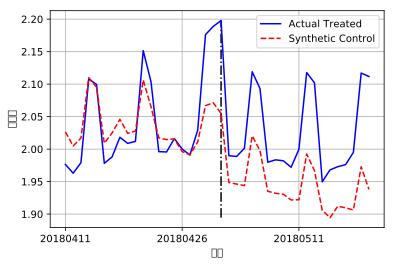

In [47]:
syn.plot(u'日期', u'作品量', u'20180501', step = 15, 
         Z_treated = syn.Z_all_treated, if_show = False, 
         X0 = syn.X0, X1 = syn.X1, Z0 = syn.Z0, Z1 = syn.Z1, Z_control = syn.Z_all_control)

In [32]:
syn.get_estimate(syn.X0, syn.X1, syn.Z0, syn.Z1, syn.Z_all_control)

(array([2.0264953 , 2.00498174, 2.01695529, 2.10998333, 2.09537977,
        2.00895316, 2.02493838, 2.0458221 , 2.02427516, 2.02772775,
        2.1063284 , 2.06504259, 2.01720381, 2.01468266, 2.0156855 ,
        1.99625591, 1.99112256, 2.01106255, 2.06689706, 2.07123687,
        2.05485026, 1.94863381, 1.94619619, 1.94378512, 2.02040851,
        1.99773512, 1.93506189, 1.93204489, 1.93066235, 1.92174944,
        1.92203375, 1.99245983, 1.96681781, 1.90570906, 1.89447077,
        1.91222464, 1.90957071, 1.90636036, 1.97288025, 1.93792342]),
 array([2.09775132e-02, 1.56338260e-01, 3.69950980e-01, 4.52733246e-01,
        0.00000000e+00, 0.00000000e+00, 6.50521303e-18, 0.00000000e+00]),
 array([1.98969682e-02, 0.00000000e+00, 0.00000000e+00, 5.53935452e-02,
        1.73067106e-08, 3.40547998e-02, 2.95568866e-02, 4.65396462e-01]))

In [49]:
ZZ = Z.ix[:, [0,1,5,6,7,8]]
XX = X.ix[[0,1,2,3,4,5,6], [0,1,5,6,7,8]]

In [50]:
syn = Synth(ZZ, XX, XX.columns[1:].tolist(), XX.columns[0], 
            ZZ.index.tolist()[10:30],
            ZZ.index.tolist()[30:50])

average treatment effect: 0.05971


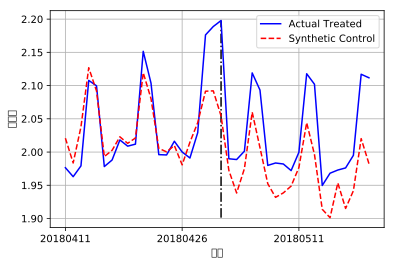

In [52]:
syn.plot(u'日期', u'作品量', u'20180501', step = 15,
         Z_treated = syn.Z_all_treated, if_show = False, 
         X0 = syn.X0, X1 = syn.X1, Z0 = syn.Z0, Z1 = syn.Z1, Z_control = syn.Z_all_control)

average treatment effect: 0.05971


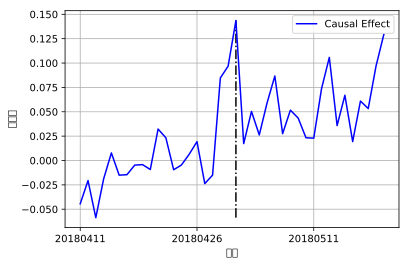

In [51]:
syn.plot(u'日期', u'作品量', u'20180501', step = 15, estimate = True,
         Z_treated = syn.Z_all_treated, if_show = False, 
         X0 = syn.X0, X1 = syn.X1, Z0 = syn.Z0, Z1 = syn.Z1, Z_control = syn.Z_all_control)

In [53]:
syn.check_fit(a.ix[:20, 'Actual'], a.ix[:20, 'Synthetic'])

Since p-value of difference between treated and synthic treated is 0.072 and 0.229, we have 95% confidence to say that our model fits well


### 代码修改前的结果

In [14]:
ZZ = Z.ix[:, [0,1,5,6,7,8]]
XX = X.ix[[0,1,2,3,4,5,6], [0,1,5,6,7,8]]

In [15]:
syn = Synth(ZZ, XX, XX.columns[1:].tolist(), XX.columns[0], 
            ZZ.index.tolist()[10:30],
            ZZ.index.tolist()[30:50])

average treatment effect: 0.13865


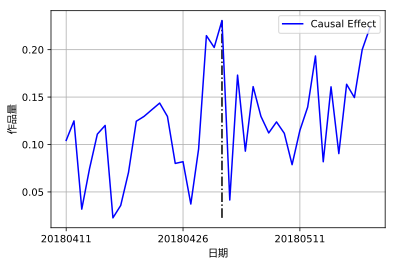

In [13]:
syn.plot(syn.X0, syn.X1, syn.Z0, syn.Z1, syn.Z_all_control, syn.Z_all_treated,
         u'日期', u'作品量', u'20180501', step = 15, estimate = True)

average treatment effect: 0.05971


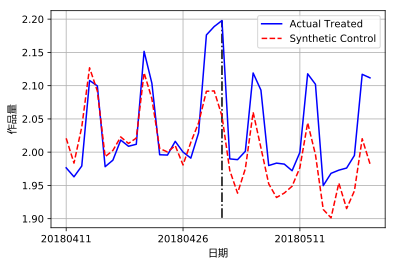

In [18]:
syn.plot(syn.X0, syn.X1, syn.Z0, syn.Z1, syn.Z_all_control, syn.Z_all_treated,
         u'日期', u'作品量', u'20180501', step = 15)